#Download dependencies

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
!pip install segmentation-models==1.0.1
!pip install tensorflow 
!pip install keras==2.3.1
!pip install -U albumentations>=0.3.0 --user 
!pip install -U --pre segmentation-models --user
!pip install split-folders
!pip install h5py==2.10.0
!pip install kaggle
!pip install keras-metrics
!pip install focal-loss

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

# this creates a symbolic link so that now the path /content/gdrive/My\ Drive/ is equal to /mydrive
!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive/

In [ ]:
%cd /content/gdrive/MyDrive/TikTok_Segmentation/dataset

In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/TikTok_Segmentation/"

In [ ]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from tensorflow import keras
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import metrics
from tensorflow.python.keras.metrics import MeanIoU

from focal_loss import BinaryFocalLoss
import splitfolders

from unet import build_unet
from dice_metric import dice_metric
from compute_iou_values import compute_iou

To download the dataset from [here](https://www.kaggle.com/datasets/tapakah68/segmentation-full-body-tiktok-dancing-dataset):

In [ ]:
!kaggle datasets download -d tapakah68/segmentation-full-body-tiktok-dancing-dataset --unzip

In [ ]:
!mkdir /content/gdrive/MyDrive/TikTok_Segmentation

In [ ]:
!chmod 600 /content/gdrive/MyDrive/TikTok_Segmentation/kaggle.json

If you have a problem with this one, you need to restart runtime and go forward.

#Data Preparations

We need to make train, valid, test folders correctly.


In [ ]:
#input_folder = 'segmentation_full_body_tik_tok_2615_img/'
#splitfolders.ratio(input_folder, output="dataset", seed=1337, ratio=(.8, .1, .1), group_prefix=None)

If you did smt wrong:

In [ ]:
#!rm -r dataset/

In [ ]:
ROOT_DIR = '/content/gdrive/MyDrive/'# your root directory
DATA_DIR = os.path.join(ROOT_DIR, 'TikTok_Segmentation/dataset')

In [ ]:
x_train_dir = os.path.join(DATA_DIR, 'train/images')
y_train_dir = os.path.join(DATA_DIR, 'train/masks')

x_valid_dir = os.path.join(DATA_DIR,  'val/images')
y_valid_dir = os.path.join(DATA_DIR, 'val/masks')

x_test_dir = os.path.join(DATA_DIR, 'test/images')
y_test_dir = os.path.join(DATA_DIR, 'test/masks')

In [ ]:
seed=24
batch_size= 8

# Initialising DataGenerator 

In [ ]:
%cd /content/gdrive/MyDrive/TikTok_Segmentation/dataset

/content/gdrive/MyDrive/TikTok_Segmentation/dataset


In [ ]:
img_data_gen_args = dict(rescale = 1/255.
                        )

mask_data_gen_args = dict(rescale = 1/255.,  #Original pixel values are 0 and 255. So rescaling to 0 to 1
                        preprocessing_function = lambda x: np.where(x>0, 1, 0).astype(x.dtype)) #Binarize the output again. 


In [ ]:
image_data_generator = ImageDataGenerator(**img_data_gen_args)
image_generator = image_data_generator.flow_from_directory("/content/gdrive/MyDrive/TikTok_Segmentation/dataset/train_images/",
                                                           seed=seed, 
                                                           batch_size=batch_size,
                                                           class_mode=None)  #Very important to set this otherwise it returns multiple numpy arrays 
                                                                            #thinking class mode is binary.

mask_data_generator = ImageDataGenerator(**mask_data_gen_args)
mask_generator = mask_data_generator.flow_from_directory("/content/gdrive/MyDrive/TikTok_Segmentation/dataset/train_masks/",
                                                         seed=seed, 
                                                         batch_size=batch_size,
                                                         color_mode = 'grayscale',   #Read masks in grayscale
                                                         class_mode=None)


valid_img_generator = image_data_generator.flow_from_directory("/content/gdrive/MyDrive/TikTok_Segmentation/dataset/val_images/", 
                                                               seed=seed, 
                                                               batch_size=batch_size, 
                                                               class_mode=None) #Default batch size 32, if not specified here
valid_mask_generator = mask_data_generator.flow_from_directory("/content/gdrive/MyDrive/TikTok_Segmentation/dataset/val_masks/",
                                                               seed=seed, 
                                                               batch_size=batch_size, 
                                                               color_mode = 'grayscale',   #Read masks in grayscale
                                                               class_mode=None)  #Default batch size 32, if not specified here

Found 2092 images belonging to 2 classes.
Found 2092 images belonging to 2 classes.
Found 261 images belonging to 2 classes.
Found 261 images belonging to 2 classes.


In [ ]:
train_generator = zip(image_generator, mask_generator)
val_generator = zip(valid_img_generator, valid_mask_generator)

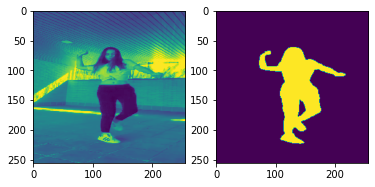

In [ ]:
x = image_generator.next()
y = mask_generator.next()
for i in range(0,1):
    image = x[i]
    mask = y[i]
    plt.subplot(1,2,1)
    plt.imshow(image[:,:,0])
    plt.subplot(1,2,2)
    plt.imshow(mask[:,:,0])
    plt.show()

# Build and compile the model

In [ ]:
IMG_HEIGHT = x.shape[1]
IMG_WIDTH  = x.shape[2]
IMG_CHANNELS = x.shape[3]

input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

model = build_unet(input_shape)

In [ ]:
model.compile(optimizer=Adam(lr = 1e-3), loss=BinaryFocalLoss(2), 
              metrics=[dice_metric])

model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_57 (Conv2D)             (None, 256, 256, 64  1792        ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_54 (BatchN  (None, 256, 256, 64  256        ['conv2d_57[0][0]']              
 ormalization)                  )                                                             

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 ormalization)                                                                                    
                                                                                                  
 activation_65 (Activation)     (None, 32, 32, 512)  0           ['batch_normalization_65[0][0]'] 
                                                                                                  
 conv2d_transpose_13 (Conv2DTra  (None, 64, 64, 256)  524544     ['activation_65[0][0]']          
 nspose)                                                                                          
                                                                                                  
 concatenate_13 (Concatenate)   (None, 64, 64, 512)  0           ['conv2d_transpose_13[0][0]',    
                                                                  'activation_59[0][0]']          
                                                                                                  
 conv2d_69

# Train the model

In [ ]:
filepath = 'my_last_model.epoch{epoch:02d}-loss{val_loss:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')

num_train_imgs = len(os.listdir('/content/gdrive/MyDrive/TikTok_Segmentation/dataset/train_masks/train'))
steps_per_epoch = num_train_imgs //(batch_size*2)

In [ ]:
%%time


callbacks = [checkpoint]
history = model.fit_generator(train_generator, validation_data=val_generator, 
                    steps_per_epoch=steps_per_epoch, 
                    validation_steps=steps_per_epoch, epochs=30, verbose=1, callbacks=callbacks )

In [ ]:
model.save('best.hdf5')

# Model Results

In [ ]:
#plot the training and validation metric and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['dice_coef']
val_acc = history.history['val_dice_coef']

plt.plot(epochs, acc, 'y', label='Training Dice')
plt.plot(epochs, val_acc, 'r', label='Validation Dice')
plt.title('Training and validation Dice')
plt.xlabel('Epochs')
plt.ylabel('Dice')
plt.legend()
plt.show()

###Test


In [ ]:
%cd /content/gdrive/MyDrive/TikTok_Segmentation/dataset

/content/gdrive/MyDrive/TikTok_Segmentation/dataset


In [ ]:
model = keras.models.load_model('best.hdf5', compile=False)

In [ ]:
test_img_generator = image_data_generator.flow_from_directory("/content/gdrive/MyDrive/TikTok_Segmentation/dataset/test_images/", 
                                                              seed=seed, 
                                                              batch_size=32, 
                                                              class_mode=None) #Default batch size 32, if not specified here

test_mask_generator = mask_data_generator.flow_from_directory("/content/gdrive/MyDrive/TikTok_Segmentation/dataset/test_masks/", 
                                                              seed=seed, 
                                                              batch_size=32, 
                                                              color_mode = 'grayscale',   #Read masks in grayscale
                                                              class_mode=None)  #Default batch size 32, if not specified here



Found 262 images belonging to 2 classes.
Found 262 images belonging to 2 classes.


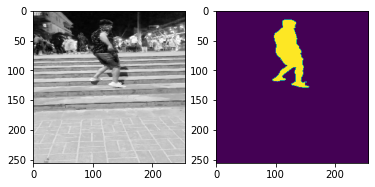

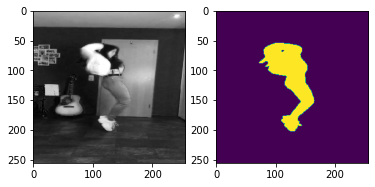

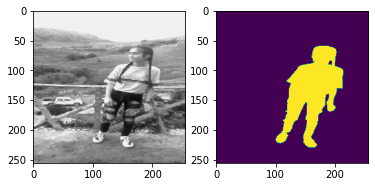

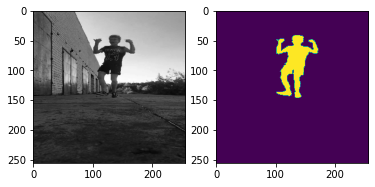

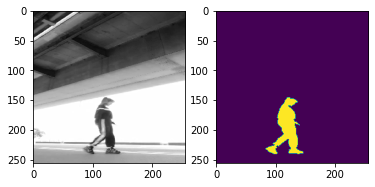

In [ ]:
a = test_img_generator.next()
b = test_mask_generator.next()
for i in range(0,5):
    image = a[i]
    mask = b[i]
    plt.subplot(1,2,1)
    plt.imshow(image[:,:,0], cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(mask[:,:,0])
    plt.show()

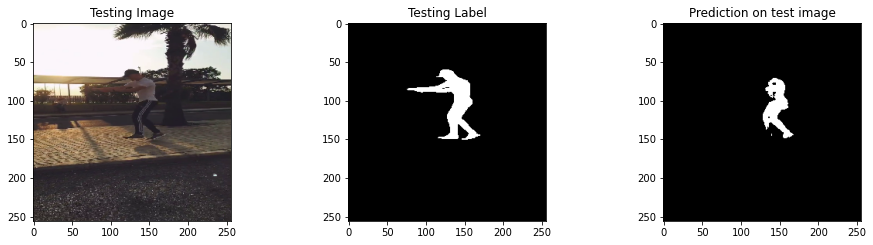

In [ ]:
test_img_number = random.randint(0, a.shape[0]-1)
test_img = a[test_img_number]
ground_truth=b[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.6).astype(np.uint8)
plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img, cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')
plt.savefig('test_prediction7')
plt.show()


In [ ]:
#IoU for a single image
IoU_values = compute_iou(model,a,b)

df = pd.DataFrame(IoU_values, columns=["IoU"])
df = df[df.IoU != 1.0]    
mean_IoU = df.mean().values
print("Mean IoU is: ", mean_IoU)    

Mean IoU is:  [0.4608159]
